# Librairies et fichiers

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy
from scipy import ndimage
from scipy import signal
from pylab import *
import time
import math
import random 

import pywt
import pywt.data

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Pour importer le datasets mnist de Keras
from tensorflow.keras.datasets.mnist import load_data


import cv2

from mpl_toolkits.mplot3d import Axes3D

import os

from copy import deepcopy

In [2]:
mit_train = pd.read_csv('mitbih_train.csv', header = None)
mit_test = pd.read_csv('mitbih_test.csv', header = None)

ptbdb_normal = pd.read_csv('ptbdb_normal.csv', header=None)
ptbdb_abnormal = pd.read_csv('ptbdb_abnormal.csv', header=None)

# constitution du jeu concaténation des jeux de donnée mitbih
ptbdb = pd.concat([ptbdb_normal, ptbdb_abnormal])

In [3]:
X_ptb = ptbdb.iloc[:,:-1]
X_test = mit_test.iloc[:,:-1]
X_train = mit_train.iloc[:,:-1]
y_ptb = ptbdb.iloc[:,-1]
y_test = mit_test.iloc[:,-1]
y_train = mit_train.iloc[:,-1]

# Fonctions

In [4]:
#isoler le dataframe signaux : suprimer les autres colonnes...

def get_cwt_line (signaux, scale, wave, line):
    # prend en entrée le jeu de données, une valeur d'échelle, un type d'ondelettes continues et une classe de signaux
    # renvoie une matrice de wavelett continues correpondant à l'entrée numéro line
    # attention, la dernière ligne de signaux contient le target
    m=signaux.shape[1] # nombre de col
    widths = np.arange(1,scale+1) # définie un intervalle à partir de l'échelle
    cwtmatr, freqs = pywt.cwt(signaux, widths, wave)
    return (signaux.iloc[line,:],freqs, cwtmatr[:,line,:-1])

In [5]:
def redim_array (original_array, width, height) :
    # prend en entrée un array avec les des  dims avec lesquelles ont veut le redimentionner
    # renvoie l'array redimentionné

    resize_array = np.zeros(shape=(width,height))

    for W in range(width):
        for H in range(height):
            new_width = int( W * original_array.shape[0] / width )
            new_height = int( H * original_array.shape[1] / height )
            resize_array[W][H] = original_array[new_width][new_height]

    return(resize_array)

# Selection des paramètres

In [6]:
scale = 8 # échelle faible pour limiter le temps de calcul
cw_type = 'mexh' # type d'ondelettes continues séléctionnable parmi la liste ci-dessous

print(pywt.wavelist(kind='continuous'))

['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']


# Pre-Processing

In [7]:
iMax = 20  #  641 lignes correspondant pour chaque valeur de cible 
#iMax=len(data_brut), il faudra trouver la valeur limite correcte pour toutes les valeurs de k
n=5 #  5 vals possible pour target
#prépparer le dataframe pour les résultats

h = int(mit_train.shape[1]/2)
width , height = scale, h #: dimension de l'image
col = range(0, width*height+1)
data_pre_ana = pd.DataFrame(columns = col)
for k in range(0,n) :
 #   print(k)
    data_brut = mit_train[mit_train.iloc[:,187]==k] # DataFrame d'entrée # DataFrame d'entrée

    signaux=data_brut.iloc[:,:-1]  # Selectionner la partie signaux de 0 à 186 

    #Boucle sur les lignes de data_brut
    for i in range(0, iMax) :
  #      print(i)
        #Traiter par ondelette le signal (fonction get_cwt)

        sig, freq, matr = get_cwt_line (signaux, scale, cw_type, i)
        #Traiter la matrice pour l'inclure dans l'array de taille prédéfinie adaptée au code CNN 
        original_array = matr
       # print(matr)
        matr=redim_array(original_array, width, height)
        matr_1D = matr.flatten()  # on transforme l amatrice en array 1D 
        # ajouter y à la fin de matr_1D, 
       # print(data_brut.shape[1])
        y = data_brut.iloc[i,data_brut.shape[1]-1]
        matr_y = np.append(matr_1D, y)
        # Enregistrer dans data_pre_ana
        a_series = pd.Series(matr_y)
        data_pre_ana = data_pre_ana.append(a_series, ignore_index=True)

In [8]:
dataTrain = data_pre_ana
nomFicTrain = 'cwt_{}x{}x{}_{}_train.csv'.format(scale, h, iMax, cw_type)
dataTrain.to_csv(nomFicTrain)

In [9]:
X_train = data_pre_ana.iloc[:,:-1]
y_train = data_pre_ana.iloc[:,-1]
# Shape of X_train and y_train

print('Shape of X:', X_train.shape)
print('Shape of y:', y_train.shape)

Shape of X: (100, 752)
Shape of y: (100,)


In [10]:
iMax = 5  # 128 lignes pour chaque valeur de cible 
#iMax=len(data_brut), il faudra trouver la valeur limite correcte pour toutes les valeurs de k
n=5 #  5 vals possible pour target
#prépparer le dataframe pour les résultats

h = int(mit_test.shape[1]/2)
width , height = scale, h #: dimension de l'image
col = range(0, width*height+1)
data_pre_ana = pd.DataFrame(columns = col)
for k in range(0,n) :
 #   print(k)
    data_brut = mit_test[mit_test.iloc[:,187]==k] # DataFrame d'entrée # DataFrame d'entrée

    signaux=data_brut.iloc[:,:-1]  # Selectionner la partie signaux de 0 à 186 

    #Boucle sur les lignes de data_brut
    for i in range(0, iMax) :
  #      print(i)
        #Traiter par ondelette le signal (fonction get_cwt)

        sig, freq, matr = get_cwt_line (signaux, scale, cw_type, i)
        #Traiter la matrice pour l'inclure dans l'array de taille prédéfinie adaptée au code CNN 
        original_array = matr
       # print(matr)
        matr=redim_array(original_array, width, height)
        matr_1D = matr.flatten()  # on transforme l amatrice en array 1D 
        # ajouter y à la fin de matr_1D, 
       # print(data_brut.shape[1])
        y = data_brut.iloc[i,data_brut.shape[1]-1]
        matr_y = np.append(matr_1D, y)
        # Enregistrer dans data_pre_ana
        a_series = pd.Series(matr_y)
        data_pre_ana = data_pre_ana.append(a_series, ignore_index=True)

In [11]:
dataTest = data_pre_ana
nomFicTest = 'cwt_{}x{}x{}_{}_test.csv'.format(scale, h, iMax, cw_type)
dataTest.to_csv(nomFicTest)

In [12]:
X_test = data_pre_ana.iloc[:,:-1]
y_test = data_pre_ana.iloc[:,-1]

# Shape of X_train and y_train
print('Shape of X:', X_test.shape)
print('Shape of y:', y_test.shape)

Shape of X: (25, 752)
Shape of y: (25,)


In [13]:
X_train = X_train / 255
X_test = X_test / 255

In [14]:
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input, Dense # Pour construire un réseau de neurones et 
                                                 # instancier une couche d'entrée et une couche dense
from tensorflow.keras.models import Model

import itertools # Pour créer des iterateurs

from sklearn import metrics # Pour évaluer les modèles

In [15]:
y_train = to_categorical(y_train, dtype = 'int') 
y_test = to_categorical(y_test, dtype = 'int')   

num_pixels = X_train.shape[1]
num_classes = y_test.shape[1]

# Modélisation

In [16]:
inputs = Input(shape = num_pixels, name = "Input")

dense1 = Dense(units = 20, activation = "tanh",kernel_initializer ='normal', name = "Dense_1")
dense2 = Dense(units = num_classes, activation = "softmax",kernel_initializer ='normal', name = "Dense_2")

x=dense1(inputs)

outputs=dense2(x)

model = Model(inputs = inputs, outputs = outputs)

In [17]:
# compilation du modele
model.compile(loss = 'categorical_crossentropy',  # fonction de perte
              optimizer = 'adam',                 # algorithme d'optimisation
              metrics = ['accuracy'])             # métrique d'évaluation

In [18]:
# entrainement du modèle
training_history = model.fit(X_train, y_train,          # données d'entraînement
                             epochs = 20,               # nombre d'epochs
                             batch_size = 200,          # taille des batchs
                             validation_split = 0.2)    # proportion de l'échantillon de test

Epoch 1/20
1/1 [==============================] - 0s 367ms/step - loss: 1.6094 - accuracy: 0.3125 - val_loss: 1.6116 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 18ms/step - loss: 1.6088 - accuracy: 0.3875 - val_loss: 1.6138 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 19ms/step - loss: 1.6082 - accuracy: 0.3625 - val_loss: 1.6160 - val_accuracy: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 18ms/step - loss: 1.6075 - accuracy: 0.3500 - val_loss: 1.6183 - val_accuracy: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 19ms/step - loss: 1.6069 - accuracy: 0.3375 - val_loss: 1.6207 - val_accuracy: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 19ms/step - loss: 1.6063 - accuracy: 0.3375 - val_loss: 1.6231 - val_accuracy: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 19ms/step - loss: 1.6056 - accuracy: 0.3375 - val_loss: 1.6256 - val_accuracy: 0.0000e+0

In [19]:
# stockage des précisions d'entraînement et de test obtenues pendant l'entraînement
train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

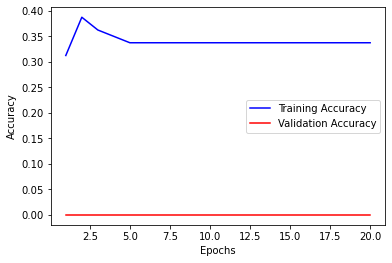

In [21]:
# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 21, 1),
         training_history.history['accuracy'],
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de test
plt.plot(np.arange(1 , 21, 1),
         training_history.history['val_accuracy'], 
         label = 'Validation Accuracy',
         color = 'red')

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show()

# Prédictions

In [22]:
# Prediction de l'échantillon de test
test_pred = model.predict(X_test)

# Evaluation du modèle
score = model.evaluate(X_test, y_test)
score

1/1 [==============================] - 0s 15ms/step - loss: 1.6093 - accuracy: 0.2000


[1.609269618988037, 0.20000000298023224]

In [23]:
# prédiction des classes de l'échantillon X_test
test_pred = model.predict(X_test)

# vecteurs d'entiers correspondant aux classes prédites et réelles
test_pred_class = test_pred.argmax(axis = 1)
y_test_class = y_test.argmax(axis = 1)

# compte-rendu évaluatif détaillé de la perfomance du modèle
print(metrics.classification_report(y_test_class, test_pred_class))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         5
           2       0.50      0.20      0.29         5
           3       0.17      0.80      0.29         5
           4       0.00      0.00      0.00         5

    accuracy                           0.20        25
   macro avg       0.13      0.20      0.11        25
weighted avg       0.13      0.20      0.11        25



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Evaluation

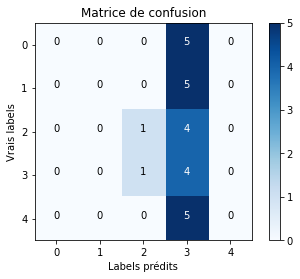

In [25]:
# Matrice de confusion

classes = range(0,5)

plt.figure()

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()